In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams.update({
    
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size' : 14
})

import pprint 
pp = pprint.PrettyPrinter(indent=2)

%config InlineBackend.figure_formats = ['svg']

In [68]:
############
############
# Adastra
############
df_mi250 = pd.read_csv("log/describe_all_adastra_gpu.csv") #MI250x
# df_mi250 = pd.read_csv("log/new-runs/describe_mi250.csv")
df_epyc = pd.read_csv("log/describe_all_cpu_epyc.csv") #AMD EPYC 7A53 64-Core Processor
# df_epyc  = pd.read_csv("log/new-runs/describe_epyc.csv")

############
# DPCPP
df_dpcpp_epyc = pd.read_csv("log/dpcpp/describe_epyc_dpcpp.csv")
df_dpcpp_genoa = pd.read_csv("log/dpcpp/describe_genoa_dpcpp.csv")
df_dpcpp_mi250 = pd.read_csv("log/dpcpp/describe_mi250_dpcpp.csv")

############
############
# Ruche
############
# df_a100  = pd.read_csv("log/describe_all_ruche_gpu.csv")
# df_xeon  = pd.read_csv("log/describe_all_ruche_cpu.csv")
df_a100  = pd.read_csv("log/new-runs/describe_a100.csv")
df_xeon  = pd.read_csv("log/new-runs/describe_xeon.csv")

############
# DPCPP
df_dpcpp_xeon  = pd.read_csv("log/dpcpp/describe_all_ruche_cpu_dpcpp.csv")


dfs = [df_mi250, df_epyc, df_a100, df_xeon, df_dpcpp_epyc, df_dpcpp_genoa, df_dpcpp_xeon, df_dpcpp_mi250]
import math
for df in dfs:
    df.drop(df[(df['error_mean']>10e-6)].index, inplace=True)
    df.drop(df[(df['error_mean'].isna())].index, inplace=True)
    df.drop(df[(df['error_mean'] == 0)].index, inplace=True)
    # df.drop(df[()].index, inplace=True)
    # df.dropna(axis = 0, how = 'all', inplace=True)

In [69]:
def create_list_from_df(df):

    kernels_name = df["kernel"].unique()

    values_all_kernels = {
        #'kernel_name': ([size1,size2,size3], [value1, value2, value3])
    }

    for kernel_type in kernels_name:
        val_one_kernel = df[df["kernel"] == kernel_type]
        values_all_kernels[kernel_type] = (val_one_kernel["global_size"],
                                           val_one_kernel['throughput_mean'],
                                           val_one_kernel['throughput_std'])

    return values_all_kernels

def plot_values(values : dict, title : str) :
    fig = plt.figure()#figsize=(12,12)
    ax  = fig.add_subplot(111)

    for key, data in values.items():
        sizes, perf, std = data

        # ax.plot(sizes,
        #             perf,
        #             # perf*10e9,
        #             'x-', label=key)
        ax.errorbar(sizes, perf, capsize=1, yerr=std, label=key)

    ax.set_title(title)
    ax.set_ylabel('Average throughput (GB/s)')
    ax.set_xlabel('Global size ($n_x \\times n_{y}$ with $n_x = 1024 $)')
    ax.set_xscale('log', base=10)

    ax.legend()
    ax.grid()
    
    # fig.savefig(f"plot{title}.pdf")
    plt.show()

In [70]:
def create_subplots(v: list, titles: list):
    fig = plt.figure(figsize=(12,10))#, constrained_layout=True)
    # fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    subfigs=[ax1, ax2, ax3, ax4]
    
    # Tracer les données
    for key, data in v[0].items():
        sizes, perf, std = data


        ax1.plot(sizes, perf, 'x-', label=key)
        
        #fake plot to set the legend
        ax.plot(0, 0, label=key)
        
    for i, vv in enumerate(v[1:]):
        for key, data in vv.items():
            sizes, perf, std = data
            
            subfigs[i+1].plot(sizes, perf, 'x-', label=key)


    box = ax.get_position()

    ax.legend(loc='lower center', bbox_to_anchor=(box.width/2 + 0.11, box.width/2 + 0.66), fancybox=True, shadow=True, ncol=5)

    #set common labels (i.e. the labels of the large subplot)
    ax.set_ylabel('Average throughput (GB/s)')
    ax.set_xlabel('Global size ($n_x \\times n_{y}$ with $n_x = 1024 $)')

    #Turn off axis for the large subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    ax1.set_title(titles[0])
    ax2.set_title(titles[1])
    ax3.set_title(titles[2])
    ax4.set_title(titles[3])

    for subfig in subfigs:
        subfig.grid(True)
        subfig.set_xscale('log', base=10)

    plt.show()
    fig.savefig("multiplot.pdf")

In [71]:
val_epyc  = create_list_from_df(df_epyc)
val_mi250 = create_list_from_df(df_mi250)
val_xeon = create_list_from_df(df_xeon)
val_a100 = create_list_from_df(df_a100)

val_xeon_dpcpp = create_list_from_df(df_dpcpp_xeon)
val_epyc_dpcpp = create_list_from_df(df_dpcpp_epyc)
val_genoa_dpcpp = create_list_from_df(df_dpcpp_genoa)
val_mi250_dpcpp = create_list_from_df(df_dpcpp_mi250)


In [72]:
# create_subplots([val_epyc, val_xeon, val_mi250, val_a100],
#                 ["CPU EPYC acpp", "CPU Xeon Gold acpp", "GPU MI250 acpp", "GPU A100 acpp"])

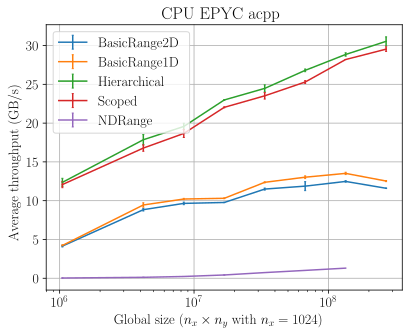

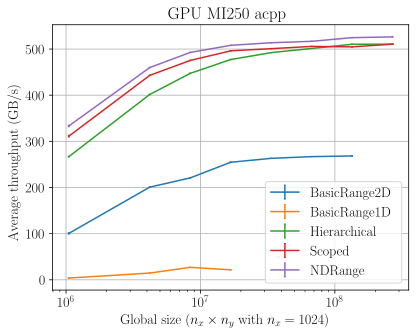

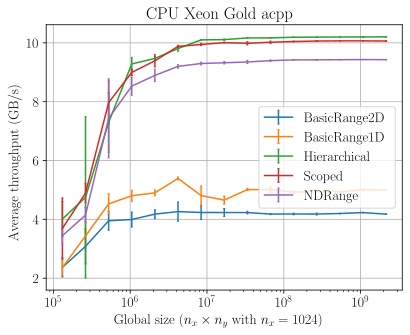

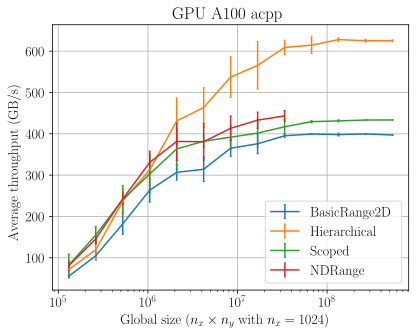

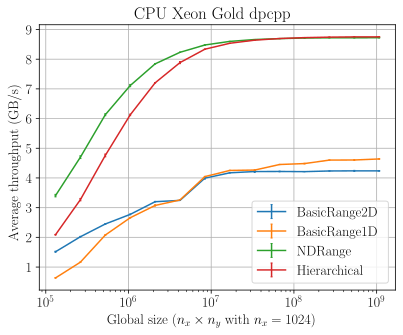

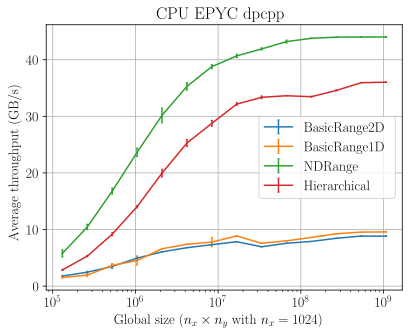

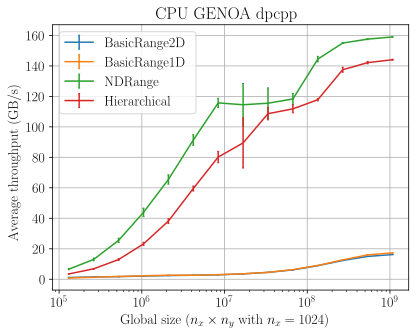

In [73]:
plot_values(val_epyc, "CPU EPYC acpp")
plot_values(val_mi250, "GPU MI250 acpp")
plot_values(val_xeon, "CPU Xeon Gold acpp")
plot_values(val_a100, "GPU A100 acpp")

plot_values(val_xeon_dpcpp, "CPU Xeon Gold dpcpp")
plot_values(val_epyc_dpcpp, "CPU EPYC dpcpp")
plot_values(val_genoa_dpcpp, "CPU GENOA dpcpp")



In [74]:
KCOLORS = [("BasicRange2D", "C0"),
           ("BasicRange1D", "C1"),
           ("NDRange",      "C4"),
           ("Hierarchical", "C2"),
           ("Scoped",       "C3"), ]

def plot_all_general_perf(values: list):
    #values = [(val_acpp, val_dpcpp, title), ...]
    fig = plt.figure(figsize=(15,10))#, constrained_layout=True)
    ax = fig.add_subplot(111)    # The big subplot for legend
    #gpu
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    #cpu
    ax3 = fig.add_subplot(234)
    ax4 = fig.add_subplot(235)
    ax5 = fig.add_subplot(236)
    
    subfigs=[ax1, ax2, ax3, ax4, ax5]
    
    #empty plot to fix legend
    for kernel_name, kernel_color in KCOLORS:
        ax.plot(0,0, label=kernel_name, color=kernel_color)
    ax.plot(0, 0, '-', color='k', label="\\texttt{acpp}")
    ax.plot(0, 0, '--', color='k', label="\\texttt{dpc++}")

    #plot actual values
    for i, vi in enumerate(values):
        for compiler_id, data_compiler in enumerate(vi[:-1]): #:-1 to get rid of the title
            if(data_compiler is not None):
                for key, data in data_compiler.items():
                    sizes, perf, std = data

                    current_color = next((c[1] for c in KCOLORS if c[0] == key), "")
                    if(current_color != ""):
                        plot_style = 'x-'

                        if(compiler_id == 1): #it's dpcpp
                            plot_style = 'x--'

                        subfigs[i].plot(sizes, perf, plot_style, color=current_color, label=key)


    box = ax.get_position()

    # ax.legend(loc='lower center', bbox_to_anchor=(box.width/2 + 0.11, box.width/2 + 0.66), fancybox=True, shadow=True, ncol=5)
    ax.legend(fontsize=18, fancybox=True, shadow=True, bbox_to_anchor=(box.width/2 + 0.57, box.width/2 + 0.56),)

    #set common labels (i.e. the labels of the large subplot)
    ax.set_ylabel('Average throughput (GB/s)')
    ax.set_xlabel('Global size ($n_x \\times n_{y}$ with $n_x = 1024 $)')

    #Turn off axis for the large subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    for i, subfig in enumerate(subfigs):
        subfig.set_title(values[i][2])
        subfig.grid(True)
        subfig.set_xscale('log', base=2)

    # plt.show()
    fig.savefig("multiplot.pdf")




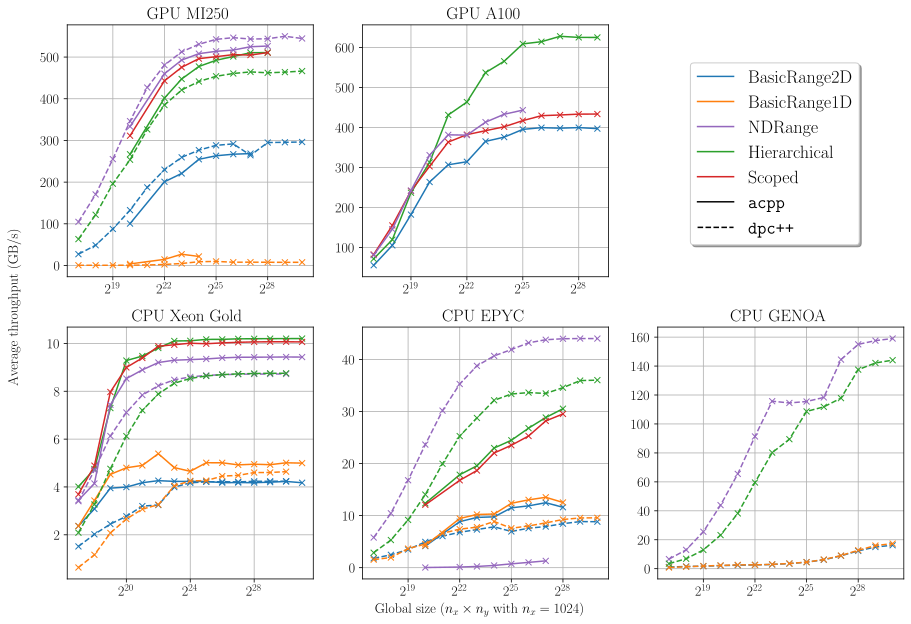

In [75]:
all_values=[
    #(val_acpp, val_dpcpp, title)
    (val_mi250, val_mi250_dpcpp, "GPU MI250"),
    (val_a100,  None,            "GPU A100"),
    (val_xeon,  val_xeon_dpcpp,  "CPU Xeon Gold"),
    (val_epyc,  val_epyc_dpcpp,  "CPU EPYC"),
    (None,      val_genoa_dpcpp, "CPU GENOA")
]

plot_all_general_perf(all_values)

# Perf portability

In [76]:
dfs_dpcpp = [df_dpcpp_mi250, None,    df_dpcpp_epyc, df_dpcpp_genoa, df_dpcpp_xeon]
dfs_acpp =  [df_mi250,       df_a100, df_epyc,       None,           df_xeon]

peak_xeon = 94
peak_a100 = 1555
peak_mi250= 1638
peak_epyc = 204.8
peak_genoa= 460.8

hw_peak_list = [peak_mi250, peak_a100, peak_epyc, peak_genoa, peak_xeon]

hw_list      = ['mi250',    'a100',    'epyc',    'genoa',    'xeon']
eff_list = ['arch', "app"] #calculating pp for arch and application efficiencies

#careful run with df list in the right order (same as hw_list)
def create_pp_values(dfs_list : list, ny_size: int):
    pp_val = {
        "BasicRange2D":{},
        "BasicRange1D":{},
        "NDRange":{},
        "Hierarchical":{},
        "Scoped":{},
    }
    
    for key in pp_val:
        for hw in hw_list:
            pp_val[key][hw] = {}
            for eff in eff_list:
                pp_val[key][hw][eff] = 0

    #we have general structure of pp_val dict of dict
    m_list_df = [] #list of dataframes we will use, same order as hw list
    for df in dfs_list:
        #we only keep the rows with targeted nvx size
        m_list_df.append(df.drop(df[(df['nvx']!=ny_size)].index) if df is not None else None)


    m_lists_impl_rt = {} #dict of lists for each impl for each hw
    for impl_name in pp_val:
        m_lists_impl_rt[impl_name] = []
        for m_df in m_list_df:
            if m_df is not None:
                # display(m_df)
                values_rt = m_df[m_df['kernel'] == impl_name]["runtime_mean"].values
                m_lists_impl_rt[impl_name].append(values_rt[0] if len(values_rt) > 0 else -1)
            else :
                m_lists_impl_rt[impl_name].append(-1)
    # pp.pprint(m_lists_impl_rt)

    #best durations for each hardware regardless of the implem
    best_rts = {}
    for i_hw, hw_name in enumerate(hw_list) :
        if m_list_df[i_hw] is not None:
            best_rts[hw_name] = m_list_df[i_hw]["runtime_mean"].min()
        else:
            best_rts[hw_name] = -1

    #Best duration for each implem; regardless of the hardware: FALSE
    # best_rts = {}
    # for impl_name in m_lists_impl_rt :
    #     #check if all values are -1, implem did not run on any hardware (e.g. scoped with dpcpp)
    #     is_identical = all(x == m_lists_impl_rt[impl_name][0] and x == -1 for x in m_lists_impl_rt[impl_name])

    #     if not is_identical:
    #         best_rts[impl_name] = min([i for i in m_lists_impl_rt[impl_name] if i > 0])
    #     else :
    #         best_rts[impl_name] = -1
        
    # for m_df in m_list_df : display(m_df)
    # print(f"BEST DURATIONS ARE")
    # pp.pprint(best_rts)

    #now we have the dropped dfs and the pp_val data template
    for key in pp_val:
        for i_hw, hw in enumerate(hw_list):

            pp_val[key][hw]["arch"] = -1
            pp_val[key][hw]["app"]  = -1
            
            current_df = m_list_df[i_hw]
            if current_df is not None:
                val = current_df[current_df['kernel'] == key]
                if val is not None:
                    pd_series_mem  = val["throughput_mean"].values
                    pd_series_rt = val["runtime_mean"].values

                    perf_mem = pd_series_mem[0] if len(pd_series_mem > 0) else -1
                    perf_rt  = pd_series_rt[0]  if len(pd_series_rt > 0) else -1
                else:
                    perf_mem = -1
                    perf_rt  = -1

                if perf_rt != -1 :
                    pp_val[key][hw]["arch"] = perf_mem/hw_peak_list[i_hw]
                    pp_val[key][hw]["app"]  = best_rts[hw]/perf_rt
                
            else:
                #if is None, the application does not run on this hw, we set pp to 0
                # print(hw_list[i_hw] + " is none")
                pp_val[key][hw]["arch"] = -1
                pp_val[key][hw]["app"]  = -1

    return pp_val

In [172]:
cpus_only    = [None,    None,    'epyc',    'genoa',    'xeon']
gpus_only    = ['mi250', 'a100', None, None, None]

def compute_pp(pp_values : dict, hw_subset : list, do_print=False):
    if do_print: pp.pprint(pp_values)
    
    nb_hw_in_subset = sum(x is not None for x in hw_subset)
    pp_arch = {}
    pp_app  = {}
    for impl in pp_values:
        # pp_arch[impl] = 0
        # pp_app[impl]  = 0
        sum_arch = 0
        sum_app = 0
        for i_hw, hw in enumerate(hw_subset):
            if(hw is not None): #if hw is none, we just skip, it's not in the H subset
                if pp_values[impl][hw]["arch"] == -1: #impl did not run on this hw, pp is 0
                    pp_arch[impl] = -1
                    pp_app[impl]  = -1
                    break
                else:
                    sum_arch += (1/pp_values[impl][hw]["arch"])
                    sum_app  +=  (1/pp_values[impl][hw]["app"])
            # else:#if at least one hw is 
            #     pp_arch[impl] = 0
            #     pp_app[impl]  = 0
        # if pp_arch[impl] == -1 or pp_app[impl] == -1 : 
        #     pp_arch[impl] = 0
        #     pp_app[impl]  = 0
        #     sum_arch = 0
        #     sum_app = 0
            # pass

        pp_arch[impl]= nb_hw_in_subset/sum_arch if sum_arch > 0 else 0
        pp_app[impl] = nb_hw_in_subset/sum_app  if sum_app  > 0 else 0
        
        if do_print:
            print(f"------- impl: {impl}")
            print(f"        pp arch : {pp_arch[impl]}")
            print(f"        pp app  : {pp_app[impl]}")
        
    return (pp_arch, pp_app)

In [87]:


acpp_pp_values  = create_pp_values(dfs_acpp, 2**14)
dpcpp_pp_values = create_pp_values(dfs_dpcpp, 2**14)

pp_acpp , pp_acpp_cpu , pp_acpp_gpu  = {"arch":"", "app":""}, {"arch":"", "app":""}, {"arch":"", "app":""}
pp_dpcpp, pp_dpcpp_cpu, pp_dpcpp_gpu = {"arch":"", "app":""}, {"arch":"", "app":""}, {"arch":"", "app":""}


#all subset: cpus and gpus
pp_acpp["arch"] , pp_acpp["app"]          = compute_pp(acpp_pp_values,  hw_list, do_print=False)
pp_dpcpp["arch"], pp_dpcpp["app"]         = compute_pp(dpcpp_pp_values, hw_list, do_print=False)

#only cpus
pp_acpp_cpu["arch"] , pp_acpp_cpu["app"]  = compute_pp(acpp_pp_values,  cpus_only, do_print=False)
pp_dpcpp_cpu["arch"], pp_dpcpp_cpu["app"] = compute_pp(dpcpp_pp_values, cpus_only, do_print=False)

#only gpus
pp_acpp_gpu["arch"] , pp_acpp_gpu["app"]  = compute_pp(acpp_pp_values,  gpus_only, do_print=False)
pp_dpcpp_gpu["arch"], pp_dpcpp_gpu["app"] = compute_pp(dpcpp_pp_values, gpus_only, do_print=False)

# pp.pprint(acpp_pp_values)
# pp.pprint(pp_acpp)

In [88]:
# data = acpp_pp_values
data          = dpcpp_pp_values
data_mean_cpu = pp_dpcpp_cpu
data_mean_gpu = pp_dpcpp_gpu
data_mean_allsubset =  pp_dpcpp

implems = data.keys()
hardware = hw_list

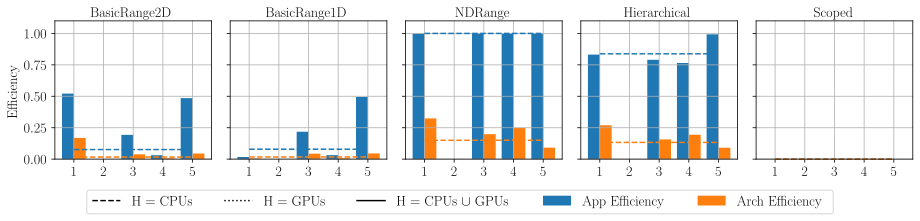

In [187]:
num_implementations = len(implems)
num_hardware = len(hardware)

fig, axs = plt.subplots(1, num_implementations, figsize=(13, 2.8))#, sharey=True)
x = np.arange(num_hardware)
bar_width = 0.4  # Adjust the width to control the spacing


for i, implem in enumerate(implems):
    app_efficiency = [data[implem][hw]['app'] if data[implem][hw]['app'] != -1 else 0 for hw in hardware]
    arch_efficiency = [data[implem][hw]['arch'] if data[implem][hw]['arch'] != -1 else 0 for hw in hardware]

    #plot bars
    axs[i].bar(x - bar_width/2, app_efficiency, bar_width,  color="C0") #label='App Efficiency',
    axs[i].bar(x + bar_width/2, arch_efficiency, bar_width, color="C1") #label='Arch Efficiency',

    #plot harmonix mean for each implem
    #TODO : line '--' for CPU, '---' for GPUs, and '-' for all subset ?
    axs[i].plot(x, [data_mean_cpu["app"][implem] for _ in range(5) ] , linestyle='--', color="C0") #label='CPU APP PerfPort',
    axs[i].plot(x, [data_mean_cpu["arch"][implem] for _ in range(5) ], linestyle='--', color="C1") #label='CPU ARCH PerfPort',

    # axs[i].plot(x, [data_mean_gpu["app"][implem] for _ in range(5) ],  linestyle=':', color="C0") #label='Harmonic Mean',
    # axs[i].plot(x, [data_mean_gpu["arch"][implem] for _ in range(5) ], linestyle=':', color="C1") #label='Harmonic Mean',

    # axs[i].plot(x, [data_mean_allsubset["app"][implem] for _ in range(5) ], linestyle='-', color="C0")
    # axs[i].plot(x, [data_mean_allsubset["arch"][implem] for _ in range(5) ], linestyle='-', color="C1")

    axs[i].xaxis.set_label_position('top') 
    axs[i].set_xlabel(implem)
    axs[i].grid()
    axs[i].set_ylim(0,1.1) #set ylim max to 1.1 so we can see
    axs[i].set_xticks(x)
    axs[i].set_xticklabels([str(j + 1) for j in range(num_hardware)])
    axs[i].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    if i != 0: axs[i].set_yticklabels([])
    # if i != 0: axs[i].yaxis.set_ticks_position('none') 


#Legend for all the fig
axs[0].bar(0, 0, color='C0', label='App Efficiency')
axs[0].bar(0, 0, color='C1', label='Arch Efficiency')
axs[0].plot(0, 0, '--', color='k', label="H = CPUs")
axs[0].plot(0, 0, ':' , color='k', label="H = GPUs")
axs[0].plot(0, 0, '-' , color='k', label="H = CPUs $\\cup$ GPUs")

plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1), borderaxespad=0)

axs[0].set_ylabel('Efficiency')


# axs[0].legend(loc='upper right', ncol=5, borderaxespad=-2.2)
# plt.savefig('pp.pdf')
plt.tight_layout()
plt.show()